### Importy

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from typing import Tuple, Callable
import pandas as pd
import numpy as np

import sys, os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, PROJECT_ROOT)


from src.performance_metrics.performance_metrics import PerformanceMetrics
from src.performance_metrics.metrics_mesaurements import compare_metrics_df, plot_execution_times
from src.data.load_data import load_breath_cancer_data, load_students_data
from src.data.data_preparation import prepare_data, encode_categorical_columns
from src.models.abstract_classifier import AbstractClassifier

from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) # ignore warnings about undefinded metrics (no predictions were made)
warnings.filterwarnings('ignore', category=ConvergenceWarning) # ignore warnings about converging in sklearn

### Załadnowanie danych

In [2]:
breast_cancer_data = load_breath_cancer_data()

breast_cancer_data.head()

,ID,Diagnosis,radius1,texture1,perimiter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimiter3,area3,smoothness3,compactness3,concavity3,concave_points3,symetry3,fractial_dimention3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
students_data = load_students_data()
students_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
students_categorical_columns = students_data.select_dtypes(include=['object']).columns.tolist()
students_categorical_columns

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [5]:
students_data = encode_categorical_columns(students_data, students_categorical_columns)
students_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


# Porównanie otrzymywanych wyników między naszą implementacją a implementacją sklear

### Pomocnicze funkcje

In [ ]:
def get_model_results(model, x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame,y_test: pd.Series) -> Tuple[PerformanceMetrics, np.ndarray, pd.Series]:
    classifier_model = AbstractClassifier(model, x_train, x_test, y_train)
    classifier_model.fit()
    predictions = classifier_model.predict()
    performance_metrics = PerformanceMetrics(predictions, y_test)
    return performance_metrics, predictions, y_test


def compare_all_metrics(performance_metrics: PerformanceMetrics, actual: pd.Series, predictions: np.ndarray) -> None:
    micro = compare_metrics_df(performance_metrics, actual, predictions, average='micro')
    macro = compare_metrics_df(performance_metrics, actual, predictions, average='macro')
    per_class = compare_metrics_df(performance_metrics, actual, predictions, average='per_class')
    weighted = compare_metrics_df(performance_metrics, actual, predictions, average='weighted')

    # displaying the results
    print("Micro Average Metrics:")
    display(micro)
    print("Macro Average Metrics:")
    display(macro)
    print("Per Class Metrics:")
    display(per_class)
    print("Weighted Average Metrics:")
    display(weighted)


def compare_times(our_function: str, sklearn_function: Callable, predictions: np.ndarray, actual: pd.Series) -> None:
    TYPES = ['micro', 'macro', 'per_class', 'weighted']
    for t in TYPES:
        print(f"--- {t} ---")
        plot_execution_times(
            our_function,
            sklearn_function,
            predictions, actual,
            ns=list(range(1, 60)),
            average=t
        )


def compare_all_times(predictions: np.ndarray, actual: pd.Series) -> None:
    compare_times('accuracy', accuracy_score, predictions, actual)
    compare_times('precision', precision_score, predictions, actual)
    compare_times('recall', recall_score, predictions, actual)
    compare_times('f1_score', f1_score, predictions, actual)

### Załadowanie danych

In [7]:
x_breast_cancer, x_test_breast_cancer, y_train_breast_cancer, y_test_breast_cancer = prepare_data(
    breast_cancer_data, target_column="Diagnosis")

In [33]:
x_students, x_test_students, y_train_students, y_test_students = prepare_data(
    students_data, target_column="G1", test_size=0.3, stratify=False)

### Modele

In [30]:
logistic_regression = LogisticRegression(max_iter=2500)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
linear_svc = LinearSVC(max_iter=2500)
mlp_classifier = MLPClassifier(max_iter=2500)

## 1. Logistic Regression

#### Breast Cancer

In [10]:
performance_metrics, predictions, actual = get_model_results(logistic_regression, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

In [11]:
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.921053,0.921053
precision,0.921053,0.921053
recall,0.921053,0.921053
f1,0.921053,0.921053


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.897817,0.921053
precision,0.935081,0.935081
recall,0.897817,0.897817
f1,0.911757,0.911757


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
B                0.898734  0.898734           0.986111  0.986111   
M                0.971429  0.971429           0.809524  0.809524   

metric                 f1            
source PerformanceMetrics   sklearn  
B                0.940397  0.940397  
M                0.883117  0.883117

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.921053,0.921053
precision,0.925516,0.925516
recall,0.921053,0.921053
f1,0.919294,0.919294


#### Students

In [34]:
performance_metrics, predictions, actual = get_model_results(logistic_regression, x_students, y_train_students, x_test_students, y_test_students)

In [35]:
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.280255,0.280255
precision,0.280255,0.280255
recall,0.280255,0.280255
f1,0.280255,0.280255


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.212513,0.280255
precision,0.236759,0.236759
recall,0.212513,0.212513
f1,0.217896,0.217896


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
3                0.000000  0.000000           0.000000  0.000000   
4                0.000000  0.000000           0.000000  0.000000   
5                0.000000  0.000000           0.000000  0.000000   
6                0.066667  0.066667           0.166667  0.166667   
7                0.500000  0.500000           0.269231  0.269231   
8                0.241379  0.241379           0.280000  0.280000   
9                0.208333  0.208333           0.151515  0.151515   
10               0.345455  0.345455           0.372549  0.372549   
11               0.275000  0.275000           0.333333  0.333333   
12               0.277778  0.277778           0.322581  0.322581   
13               0.357143  0.357143           0.344828  0.344828   
14               0.193548  0.193548           0.187500  0.187500   
15               0.277778  0.277778           0.333333  0.333333   
16               0.181818  0.181818           0.142857  0.142857   
17               0.600000  0.600000           0.375000  0.375000   
18               0.500000  0.500000           0.333333  0.333333   
19               0.000000  0.000000           0.000000  0.000000   

metric                 f1            
source PerformanceMetrics   sklearn  
3                0.000000  0.000000  
4                0.000000  0.000000  
5                0.000000  0.000000  
6                0.095238  0.095238  
7                0.350000  0.350000  
8                0.259259  0.259259  
9                0.175439  0.175439  
10               0.358491  0.358491  
11               0.301370  0.301370  
12               0.298507  0.298507  
13               0.350877  0.350877  
14               0.190476  0.190476  
15               0.303030  0.303030  
16               0.160000  0.160000  
17               0.461538  0.461538  
18               0.400000  0.400000  
19               0.000000  0.000000

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.280255,0.280255
precision,0.295148,0.295148
recall,0.280255,0.280255
f1,0.282079,0.282079


## 2. Decision Tree

#### Breast Cancer

In [60]:
performance_metrics, predictions, actual = get_model_results(decision_tree, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

In [61]:
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.938596,0.938596
precision,0.938596,0.938596
recall,0.938596,0.938596
f1,0.938596,0.938596


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.936508,0.938596
precision,0.932362,0.932362
recall,0.936508,0.936508
f1,0.934348,0.934348


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
B                0.957746  0.957746           0.944444  0.944444   
M                0.906977  0.906977           0.928571  0.928571   

metric                 f1            
source PerformanceMetrics   sklearn  
B                0.951049  0.951049  
M                0.917647  0.917647

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.938596,0.938596
precision,0.939042,0.939042
recall,0.938596,0.938596
f1,0.938743,0.938743


#### Students

In [36]:
performance_metrics, predictions, actual = get_model_results(decision_tree, x_students, y_train_students, x_test_students, y_test_students)
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.242038,0.242038
precision,0.242038,0.242038
recall,0.242038,0.242038
f1,0.242038,0.242038


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.180721,0.242038
precision,0.190840,0.190840
recall,0.180721,0.180721
f1,0.183151,0.183151


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
3                0.000000  0.000000           0.000000  0.000000   
4                0.000000  0.000000           0.000000  0.000000   
5                0.000000  0.000000           0.000000  0.000000   
6                0.000000  0.000000           0.000000  0.000000   
7                0.350000  0.350000           0.269231  0.269231   
8                0.125000  0.125000           0.120000  0.120000   
9                0.128205  0.128205           0.151515  0.151515   
10               0.387097  0.387097           0.235294  0.235294   
11               0.232558  0.232558           0.303030  0.303030   
12               0.204545  0.204545           0.290323  0.290323   
13               0.370370  0.370370           0.344828  0.344828   
14               0.354839  0.354839           0.343750  0.343750   
15               0.125000  0.125000           0.133333  0.133333   
16               0.300000  0.300000           0.214286  0.214286   
17               0.000000  0.000000           0.000000  0.000000   
18               0.666667  0.666667           0.666667  0.666667   
19               0.000000  0.000000           0.000000  0.000000   

metric                 f1            
source PerformanceMetrics   sklearn  
3                0.000000  0.000000  
4                0.000000  0.000000  
5                0.000000  0.000000  
6                0.000000  0.000000  
7                0.304348  0.304348  
8                0.122449  0.122449  
9                0.138889  0.138889  
10               0.292683  0.292683  
11               0.263158  0.263158  
12               0.240000  0.240000  
13               0.357143  0.357143  
14               0.349206  0.349206  
15               0.129032  0.129032  
16               0.250000  0.250000  
17               0.000000  0.000000  
18               0.666667  0.666667  
19               0.000000  0.000000

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.242038,0.242038
precision,0.262368,0.262368
recall,0.242038,0.242038
f1,0.247057,0.247057


## 3. Random Forest

#### Breast Cancer

In [62]:
performance_metrics, predictions, actual = get_model_results(random_forest, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

In [63]:
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.973684,0.973684
precision,0.973684,0.973684
recall,0.973684,0.973684
f1,0.973684,0.973684


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.964286,0.973684
precision,0.980000,0.980000
recall,0.964286,0.964286
f1,0.971277,0.971277


Per Class Metrics:


metric          precision                     recall            \
source PerformanceMetrics sklearn PerformanceMetrics   sklearn   
B                    0.96    0.96           1.000000  1.000000   
M                    1.00    1.00           0.928571  0.928571   

metric                 f1            
source PerformanceMetrics   sklearn  
B                0.979592  0.979592  
M                0.962963  0.962963

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.973684,0.973684
precision,0.974737,0.974737
recall,0.973684,0.973684
f1,0.973465,0.973465


#### Students

In [37]:
performance_metrics, predictions, actual = get_model_results(random_forest, x_students, y_train_students, x_test_students, y_test_students)
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.267516,0.267516
precision,0.267516,0.267516
recall,0.267516,0.267516
f1,0.267516,0.267516


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.194353,0.267516
precision,0.234030,0.234030
recall,0.194353,0.194353
f1,0.203503,0.203503


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
3                0.000000  0.000000           0.000000  0.000000   
4                0.000000  0.000000           0.000000  0.000000   
5                0.000000  0.000000           0.000000  0.000000   
6                0.000000  0.000000           0.000000  0.000000   
7                0.294118  0.294118           0.192308  0.192308   
8                0.160000  0.160000           0.160000  0.160000   
9                0.194444  0.194444           0.212121  0.212121   
10               0.326531  0.326531           0.313725  0.313725   
11               0.209302  0.209302           0.272727  0.272727   
12               0.212766  0.212766           0.322581  0.322581   
13               0.434783  0.434783           0.344828  0.344828   
14               0.315789  0.315789           0.375000  0.375000   
15               0.230769  0.230769           0.200000  0.200000   
16               0.500000  0.500000           0.285714  0.285714   
17               0.500000  0.500000           0.125000  0.125000   
18               0.600000  0.600000           0.500000  0.500000   
19               0.000000  0.000000           0.000000  0.000000   

metric                 f1            
source PerformanceMetrics   sklearn  
3                0.000000  0.000000  
4                0.000000  0.000000  
5                0.000000  0.000000  
6                0.000000  0.000000  
7                0.232558  0.232558  
8                0.160000  0.160000  
9                0.202899  0.202899  
10               0.320000  0.320000  
11               0.236842  0.236842  
12               0.256410  0.256410  
13               0.384615  0.384615  
14               0.342857  0.342857  
15               0.214286  0.214286  
16               0.363636  0.363636  
17               0.200000  0.200000  
18               0.545455  0.545455  
19               0.000000  0.000000

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.267516,0.267516
precision,0.283424,0.283424
recall,0.267516,0.267516
f1,0.267930,0.267930


## 4. SVM

#### Breast Cancer

In [64]:
performance_metrics, predictions, actual = get_model_results(linear_svc, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

In [65]:
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.377193,0.377193
precision,0.377193,0.377193
recall,0.377193,0.377193
f1,0.377193,0.377193


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.506944,0.377193
precision,0.685841,0.685841
recall,0.506944,0.506944
f1,0.284666,0.284666


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
B                1.000000  1.000000           0.013889  0.013889   
M                0.371681  0.371681           1.000000  1.000000   

metric                 f1            
source PerformanceMetrics   sklearn  
B                0.027397  0.027397  
M                0.541935  0.541935

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.377193,0.377193
precision,0.768514,0.768514
recall,0.377193,0.377193
f1,0.216964,0.216964


#### Students

In [38]:
performance_metrics, predictions, actual = get_model_results(linear_svc, x_students, y_train_students, x_test_students, y_test_students)
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.197452,0.197452
precision,0.197452,0.197452
recall,0.197452,0.197452
f1,0.197452,0.197452


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.155270,0.197452
precision,0.161598,0.161598
recall,0.155270,0.155270
f1,0.147593,0.147593


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
3                0.000000  0.000000           0.000000  0.000000   
4                0.000000  0.000000           0.000000  0.000000   
5                0.000000  0.000000           0.000000  0.000000   
6                0.100000  0.100000           0.333333  0.333333   
7                0.312500  0.312500           0.192308  0.192308   
8                0.200000  0.200000           0.240000  0.240000   
9                0.222222  0.222222           0.060606  0.060606   
10               0.250000  0.250000           0.274510  0.274510   
11               0.166667  0.166667           0.181818  0.181818   
12               0.111111  0.111111           0.129032  0.129032   
13               0.269231  0.269231           0.241379  0.241379   
14               0.212121  0.212121           0.218750  0.218750   
15               0.263158  0.263158           0.333333  0.333333   
16               0.181818  0.181818           0.142857  0.142857   
17               0.333333  0.333333           0.125000  0.125000   
18               0.125000  0.125000           0.166667  0.166667   
19               0.000000  0.000000           0.000000  0.000000   

metric                 f1            
source PerformanceMetrics   sklearn  
3                0.000000  0.000000  
4                0.000000  0.000000  
5                0.000000  0.000000  
6                0.153846  0.153846  
7                0.238095  0.238095  
8                0.218182  0.218182  
9                0.095238  0.095238  
10               0.261682  0.261682  
11               0.173913  0.173913  
12               0.119403  0.119403  
13               0.254545  0.254545  
14               0.215385  0.215385  
15               0.294118  0.294118  
16               0.160000  0.160000  
17               0.181818  0.181818  
18               0.142857  0.142857  
19               0.000000  0.000000

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.197452,0.197452
precision,0.214197,0.214197
recall,0.197452,0.197452
f1,0.196608,0.196608


## 5. MLPClassifier

#### Breast Cancer

In [67]:
performance_metrics, predictions, actual = get_model_results(mlp_classifier, x_breast_cancer, y_train_breast_cancer, x_test_breast_cancer, y_test_breast_cancer)

In [68]:
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.429825,0.429825
precision,0.429825,0.429825
recall,0.429825,0.429825
f1,0.429825,0.429825


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.508929,0.429825
precision,0.512900,0.512900
recall,0.508929,0.508929
f1,0.413534,0.413534


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
B                0.652174  0.652174           0.208333  0.208333   
M                0.373626  0.373626           0.809524  0.809524   

metric                 f1            
source PerformanceMetrics   sklearn  
B                0.315789  0.315789  
M                0.511278  0.511278

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.429825,0.429825
precision,0.549551,0.549551
recall,0.429825,0.429825
f1,0.387812,0.387812


#### Students

In [39]:
performance_metrics, predictions, actual = get_model_results(mlp_classifier, x_students, y_train_students, x_test_students, y_test_students)
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.22293,0.22293
precision,0.22293,0.22293
recall,0.22293,0.22293
f1,0.22293,0.22293


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.154849,0.222930
precision,0.157642,0.157642
recall,0.154849,0.154849
f1,0.152135,0.152135


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
3                0.000000  0.000000           0.000000  0.000000   
4                0.000000  0.000000           0.000000  0.000000   
5                0.000000  0.000000           0.000000  0.000000   
6                0.166667  0.166667           0.333333  0.333333   
7                0.173913  0.173913           0.153846  0.153846   
8                0.238095  0.238095           0.200000  0.200000   
9                0.200000  0.200000           0.181818  0.181818   
10               0.408163  0.408163           0.392157  0.392157   
11               0.142857  0.142857           0.151515  0.151515   
12               0.142857  0.142857           0.161290  0.161290   
13               0.137931  0.137931           0.137931  0.137931   
14               0.309524  0.309524           0.406250  0.406250   
15               0.153846  0.153846           0.133333  0.133333   
16               0.272727  0.272727           0.214286  0.214286   
17               0.000000  0.000000           0.000000  0.000000   
18               0.333333  0.333333           0.166667  0.166667   
19               0.000000  0.000000           0.000000  0.000000   

metric                 f1            
source PerformanceMetrics   sklearn  
3                0.000000  0.000000  
4                0.000000  0.000000  
5                0.000000  0.000000  
6                0.222222  0.222222  
7                0.163265  0.163265  
8                0.217391  0.217391  
9                0.190476  0.190476  
10               0.400000  0.400000  
11               0.147059  0.147059  
12               0.151515  0.151515  
13               0.137931  0.137931  
14               0.351351  0.351351  
15               0.142857  0.142857  
16               0.240000  0.240000  
17               0.000000  0.000000  
18               0.222222  0.222222  
19               0.000000  0.000000

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.222930,0.222930
precision,0.223134,0.223134
recall,0.222930,0.222930
f1,0.220790,0.220790


# Porównanie wydajności czasowej naszej implementacji a implementacji sklearn

- Wyniki liczone na podstawie ostatniego klasyfikatora
- Porównanie czasowe wykonane tylko raz, ponieważ w nim liczy się czas obliczeń, a nie predykcje poszczególnych modeli

--- micro ---


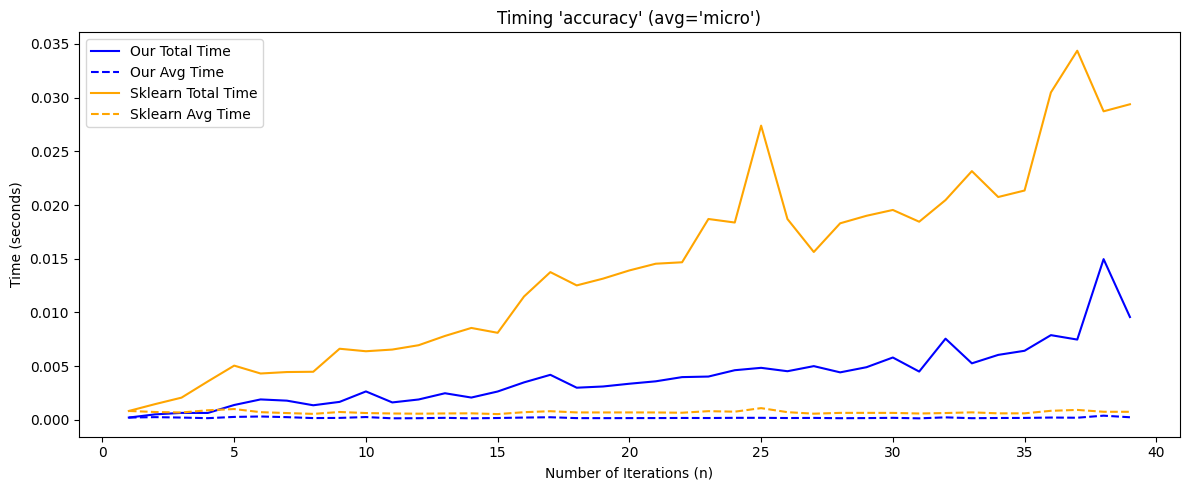

--- macro ---


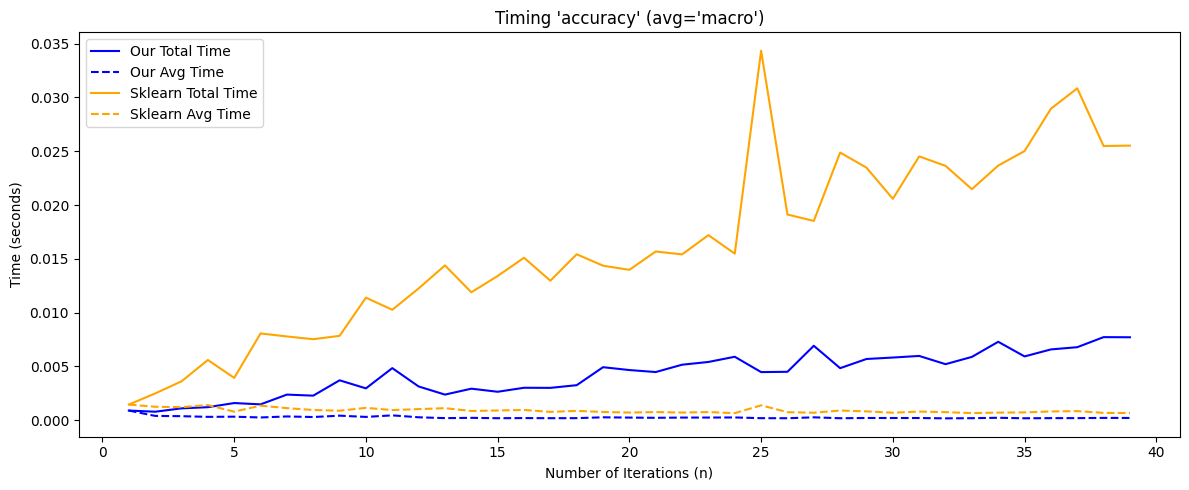

--- per_class ---


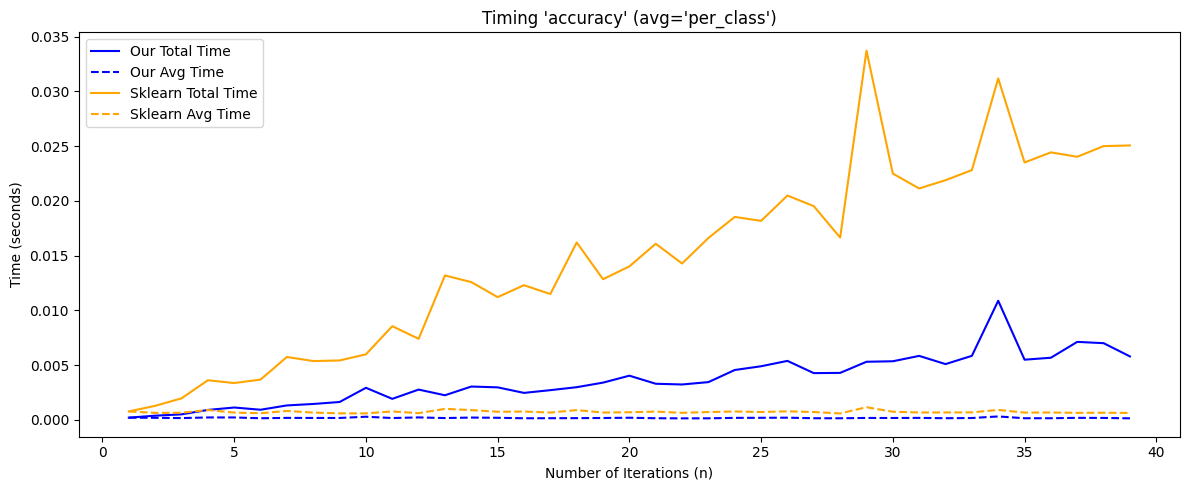

--- weighted ---


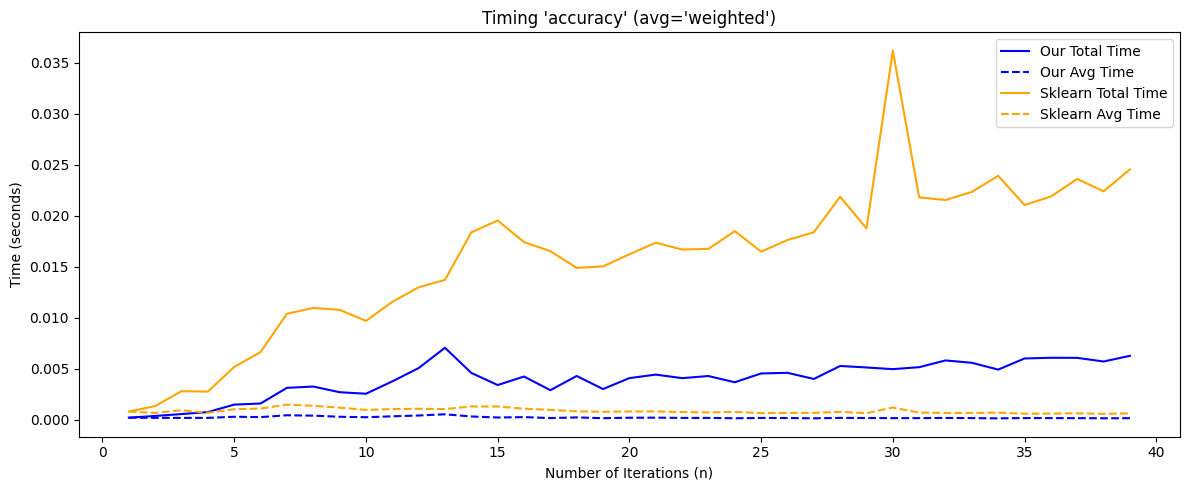

--- micro ---


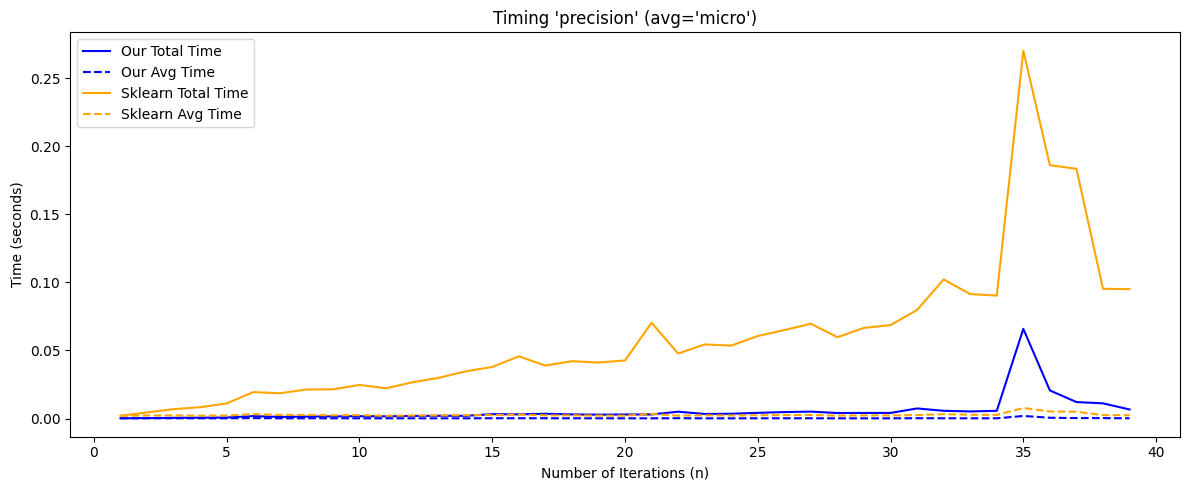

--- macro ---


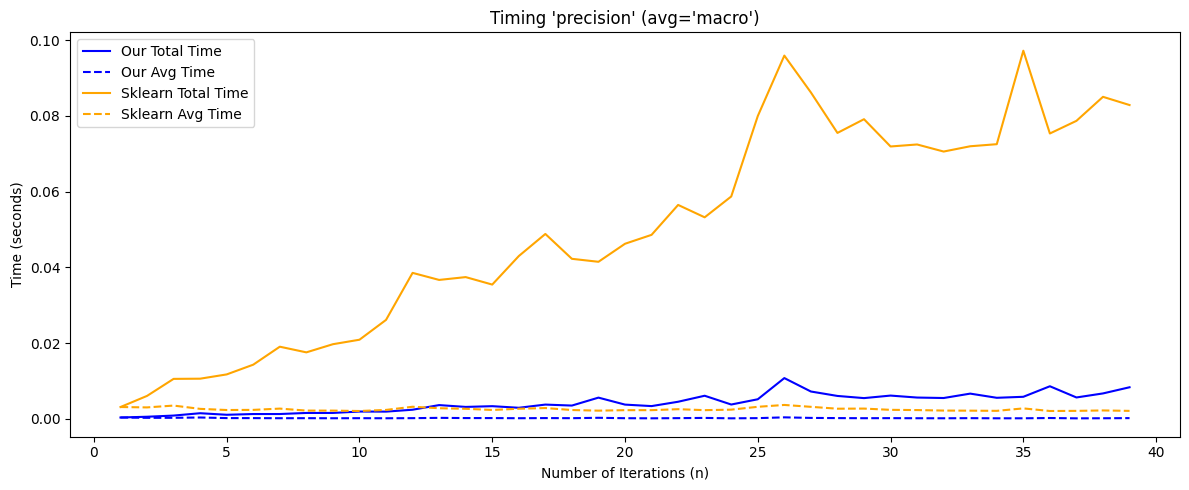

--- per_class ---


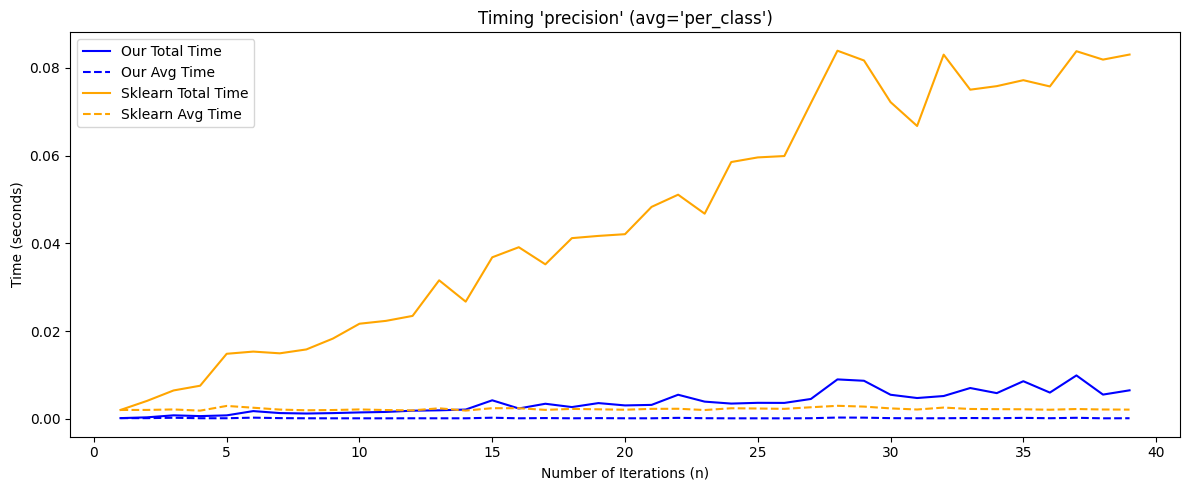

--- weighted ---


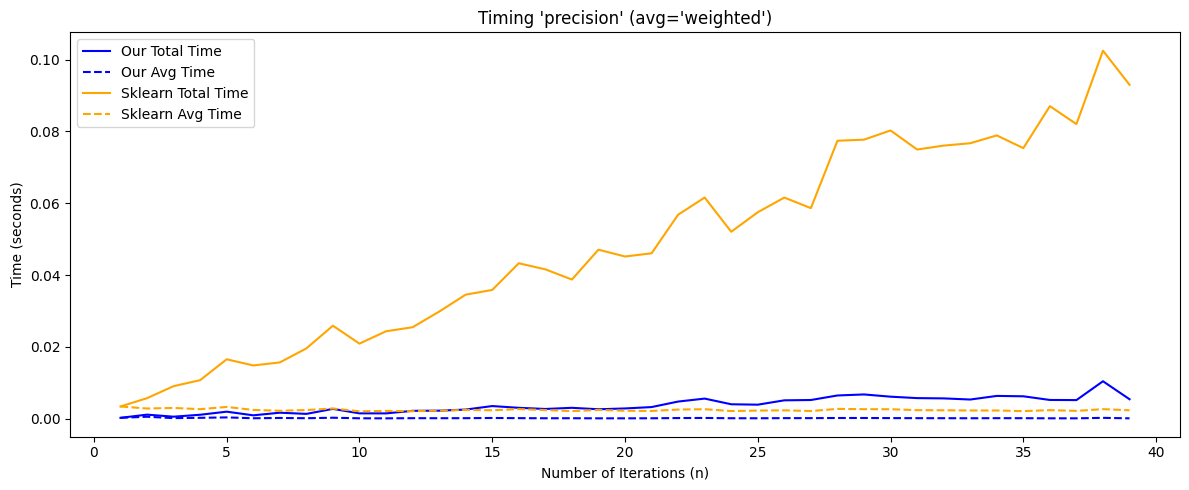

--- micro ---


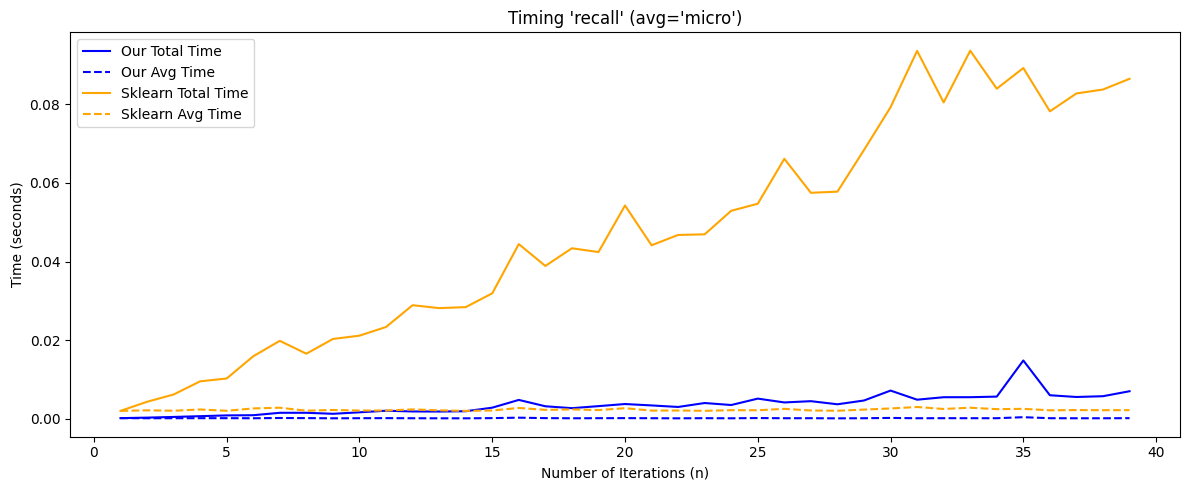

--- macro ---


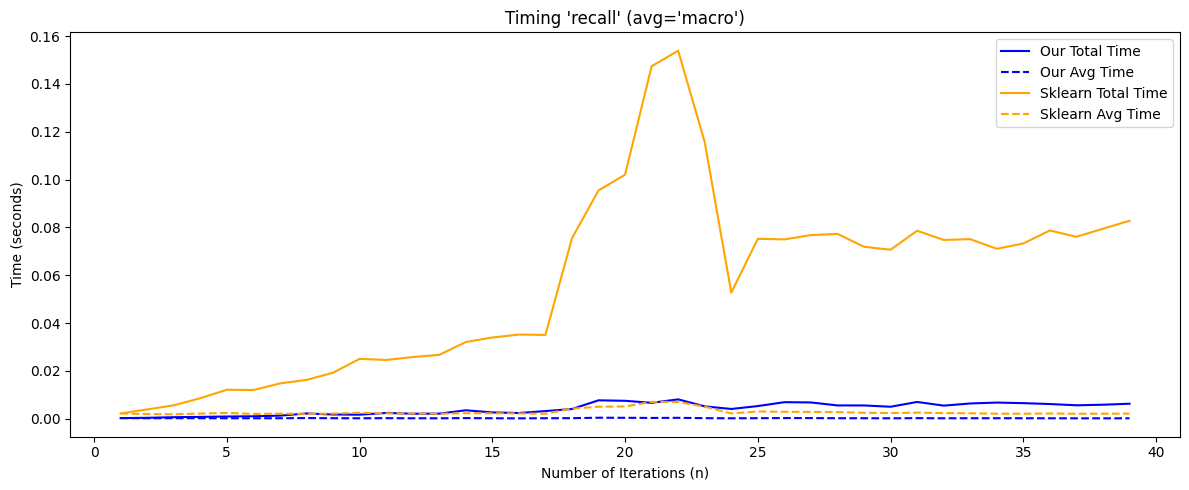

--- per_class ---


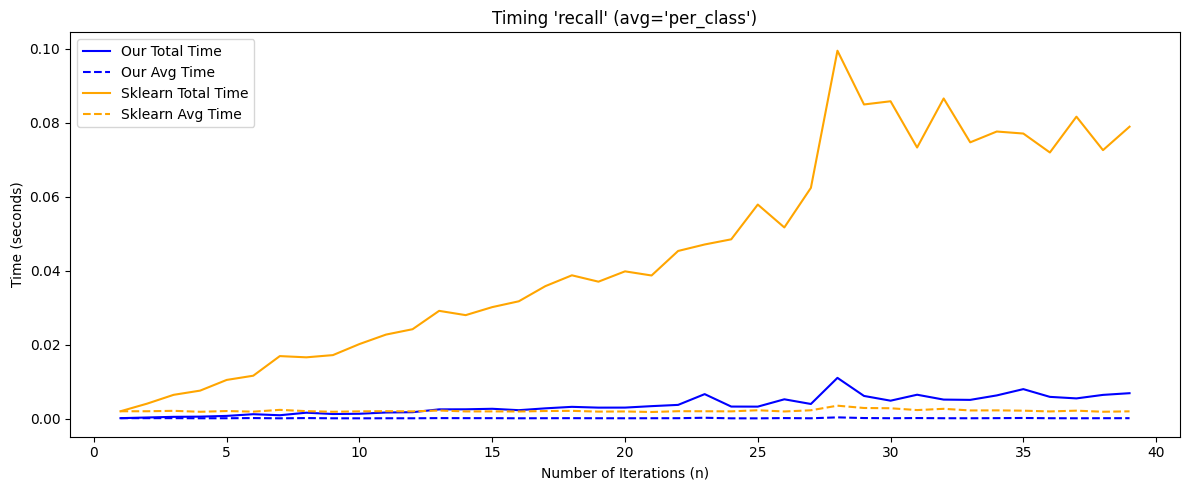

--- weighted ---


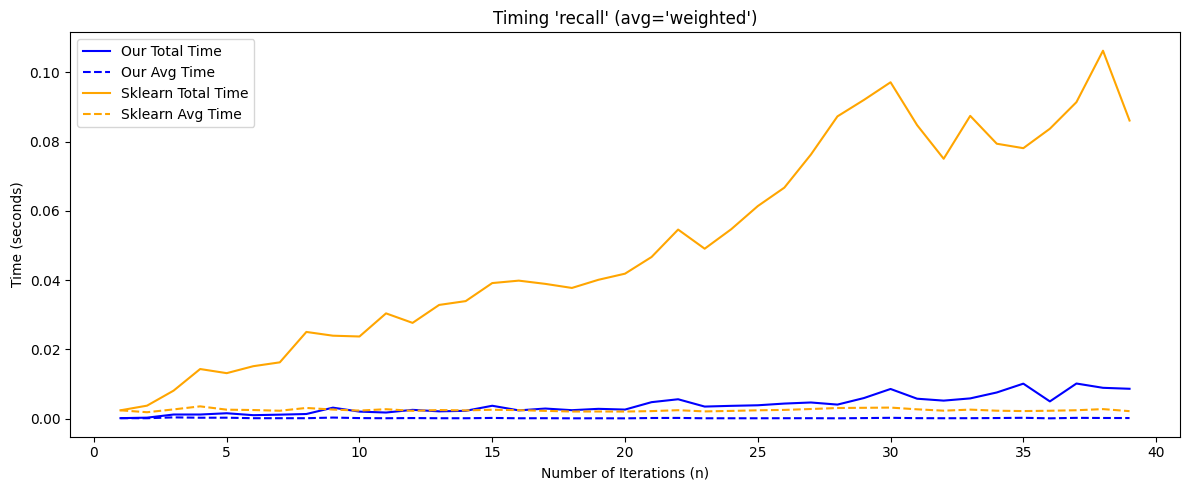

--- micro ---


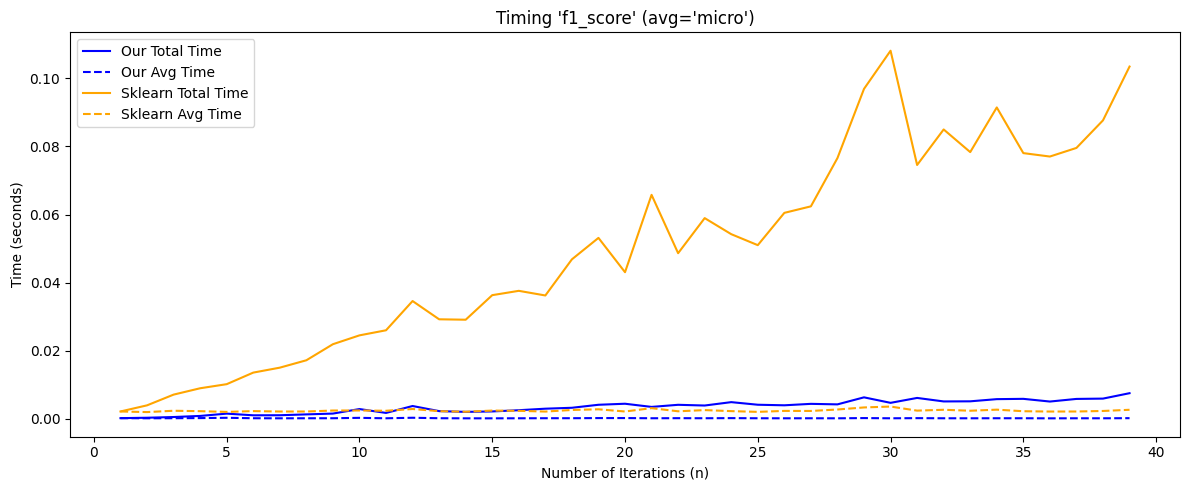

--- macro ---


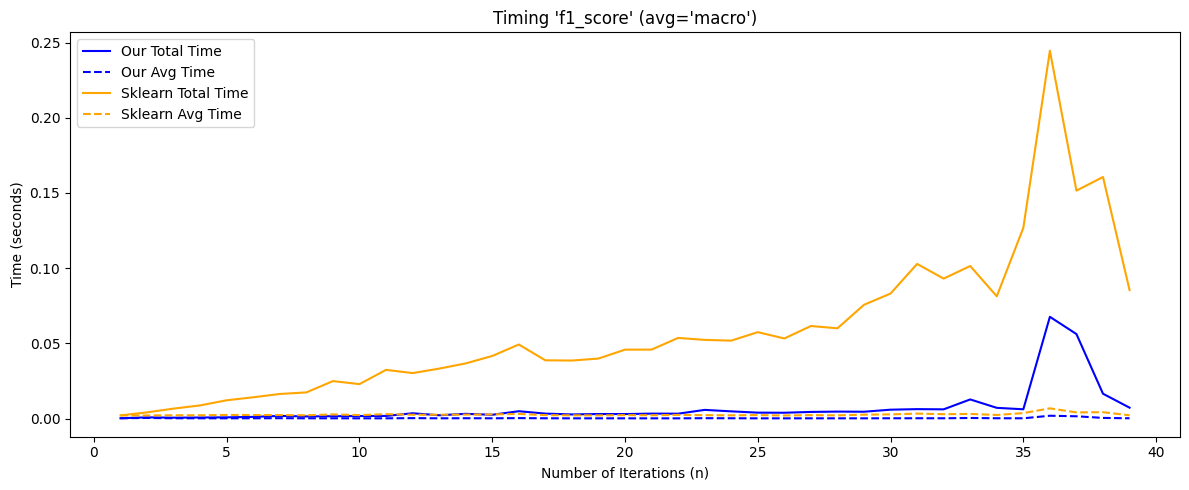

--- per_class ---


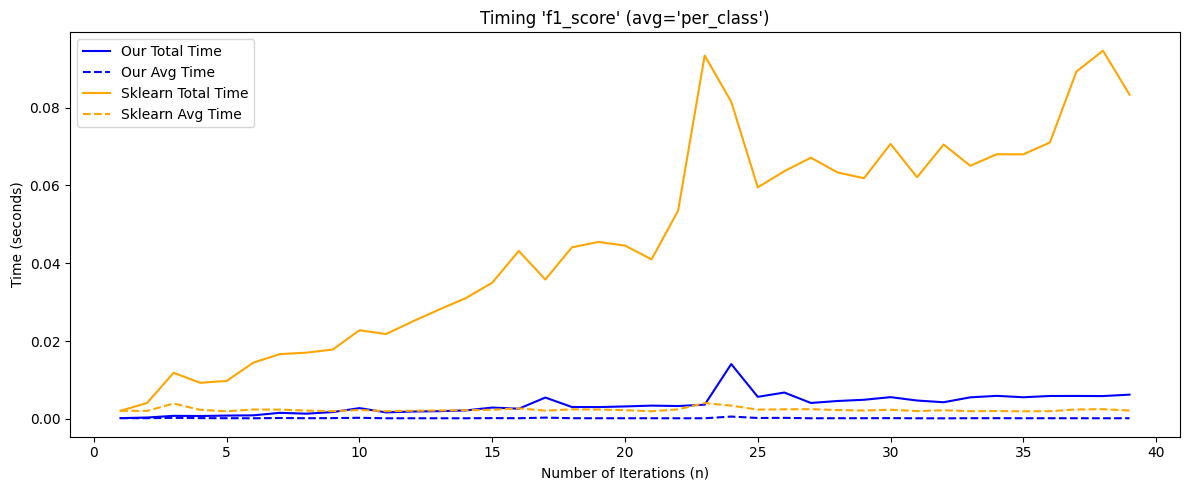

--- weighted ---


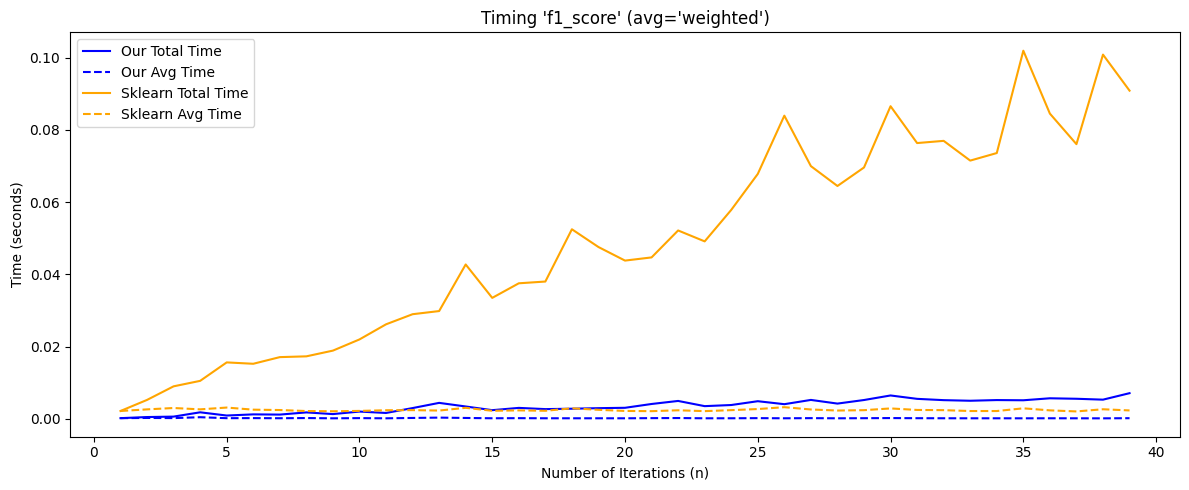

In [70]:
compare_all_times(predictions, actual)

# Wnioski

- Zarówno nasza implementacja, jak i ta z biblioteki scikit-learn zwracają identyczne wyniki na podstawie tych samych predykcji i wartości rzeczywistych.
- Jedyną różnicą jest accuracy w ujęciu „macro” — funkcja accuracy_score nie oferuje takiego trybu i domyślnie zwraca zwykłą wartość accuracy.
- Sklearn nie obsługuje też accuracy „per_class”, więc tę metrykę pominęliśmy w porównaniach.
- W kwestii wydajności czasowej mierzono czasy wykonywania dla 1–40 iteracji i liczone były czasy średnie. W obu scenariuszach nasza implementacja okazała się szybsza.